## Main Code

In [1]:
## Import packages
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
import cvxpy as cp
import time
from scipy.integrate import odeint
import control as ct
import control.optimal as obc
from scipy.spatial.transform import Rotation
import math

In [2]:
## Run Necessary Functions
%run attitude_conversions.ipynb
%run spacecraft_model.ipynb
%run saturated_pd_controller.ipynb
%run res_clf_qp_controller.ipynb
%run od_clf_qp_controller.ipynb
%run od_clf_cbf_qp_controller.ipynb
%run plot_settings.ipynb

In [3]:
# System Parameters
J = np.array([[1.8140, -0.1185, 0.0275], 
              [-0.1185, 1.7350, 0.0169], 
              [0.0275, 0.0169, 3.4320]])

u_max = 0.123
u_min = -0.123
h_max = 0.50
h_min = -0.50

# Define initial states
theta = np.array([140, 20, 100]) * (np.pi / 180) # Initial condition for 3-2-1 Euler angles
sigmai = euler_to_mrps(theta)
wi = np.array([0.1, 0.1, 0.1]) * 0
hi = np.array([0., 0., 0.])
x0 = [sigmai[0], sigmai[1], sigmai[2], wi[0], wi[1], wi[2], hi[0], hi[1], hi[2]]

# tspan = [0, 50]  # for 3D comparison plot
# tspan = [0, 45]  # for controllers' comparison plot
# tspan = [0, 100]  # for Pareto plot
dt = 0.1

## Pareto Curve

In [4]:
tspan = [0, 100]  # for Pareto plot

In [5]:
## Spacecraft Simulation Using Nonlinear Optimal Control
Tfinals = np.unique(np.logspace(np.log10(1), np.log10(100), num=80, endpoint=True, dtype='int'))
Tpoints_active_state_constraint = np.array([])
Tpoints_active_input_constraint = np.array([])
J_NonlinearOptimalControl = np.zeros(len(Tfinals))

# Define the spacecraft dynamics as an input/output system
spacecraft = ct.NonlinearIOSystem(spacecraft_plant, spacecraft_output, states=9, name='spacecraft', inputs=('u_1', 'u_2', 'u_3'), outputs=('sigma_1', 'sigma_2', 'sigma_3', 'omega_1', 'omega_2', 'omega_3', 'h_w1', 'h_w2', 'h_w3'))

# Define cost
u0 = [0., 0., 0.]
xf = [0., 0., 0., 0., 0., 0., 0., 0., 0.]
uf = [0., 0., 0.]
tspan = [0, 100]
Tf = tspan[1]
# Tf = 17

Q = np.diag([1, 1, 1, 1, 1, 1, 1, 1, 1]) * 1           # states penalty
R = np.diag([1, 1, 1])                                 # inputs penalty
Qf = np.diag([1, 1, 1, 1, 1, 1, 1, 1, 1]) * 10000      # get close to final point

traj_cost = obc.quadratic_cost(spacecraft, None, R)  #, x0=x0, u0=u0)
# term_cost = obc.quadratic_cost(spacecraft, Qf, 0, x0=xf, u0=uf)

# Define constraints
constraints = [obc.state_range_constraint(spacecraft, [-1, -1, -1, -1, -1, -1, h_min, h_min, h_min], [1, 1, 1, 1, 1, 1, h_max, h_max, h_max]),
               obc.input_range_constraint(spacecraft, [u_min, u_min, u_min], [u_max, u_max, u_max])]

sigma_threshold = 0.02
omega_threshold = 0.005
term_constraint = [obc.state_range_constraint(spacecraft, [-sigma_threshold, -sigma_threshold, -sigma_threshold, -omega_threshold, -omega_threshold, -omega_threshold, h_min, h_min, h_min], [sigma_threshold, sigma_threshold, sigma_threshold, omega_threshold, omega_threshold, omega_threshold, h_max, h_max, h_max]),
                   obc.input_range_constraint(spacecraft, [u_min, u_min, u_min], [u_max, u_max, u_max])]

for T in enumerate(Tfinals):
    timepts = np.linspace(0, T[1], 20, endpoint=True) # Best is 20
    
    result = obc.solve_ocp(spacecraft, timepts, x0, traj_cost,
                        trajectory_constraints=constraints,
                        #    terminal_cost=term_cost,
                        initial_guess=u0,
                        terminal_constraints=term_constraint,
                        print_summary=True,
                        minimize_method='SLSQP',
                        minimize_options={'maxiter':300, 'disp':True, 'ftol':1.0e-8},
                        minimize_kwargs={'tol':1.0e-6},
                        # basis=flat.BezierFamily(6, T=Tf),
                        solve_ivp_method='RK45',
                        solve_ivp_kwargs={'atol':1e-6, 'rtol':1e-3},
                        
                        # minimize_method='SLSQP',
                        # minimize_options={'maxiter':300, 'disp':True, 'ftol':1.0e-5},
                        # minimize_kwargs={'tol':1.0e-5},
                        # solve_ivp_kwargs={'method':'DOP853', 'atol':1e-15, 'rtol':1e-12},
                        )

    # Simulate the system dynamics (open loop)
    resp = ct.input_output_response(spacecraft, timepts, result.inputs, x0, t_eval=np.linspace(0, T[1], T[1] * 10 + 1))
    t, x, u = resp.time, resp.outputs, resp.inputs
    J_NonlinearOptimalControl[T[0]] = result.cost

    h_threshold = 0.01
    if np.any(np.logical_and((h_max - h_threshold) <= x[6, :], x[6, :] <= (h_max + h_threshold))) or np.any(np.logical_and((h_min - h_threshold) <= x[6, :], x[6, :] <= (h_min + h_threshold))) or np.any(np.logical_and((h_max - h_threshold) <= x[7, :], x[7, :] <= (h_max + h_threshold))) or np.any(np.logical_and((h_min - h_threshold) <= x[7, :], x[7, :] <= (h_min + h_threshold))) or np.any(np.logical_and((h_max - h_threshold) <= x[8, :], x[8, :] <= (h_max + h_threshold))) or np.any(np.logical_and((h_min - h_threshold) <= x[8, :], x[8, :] <= (h_min + h_threshold))):
        print('h_max or h_min reached')
        Tpoints_active_state_constraint = np.append(Tpoints_active_state_constraint, T[1])
    
    if np.any(u[0, :] >= u_max) or np.any(u[0, :] <= u_min) or np.any(u[1, :] >= u_max) or np.any(u[1, :] <= u_min) or np.any(u[2, :] >= u_max) or np.any(u[2, :] <= u_min):
        print('u_max or u_min reached')
        Tpoints_active_input_constraint = np.append(Tpoints_active_input_constraint, T[1])

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 0.04277337788929901
            Iterations: 21
            Function evaluations: 4131
            Gradient evaluations: 17
Summary statistics:
* Cost function calls: 4131
* Constraint calls: 4390
* System simulations: 1
* Final cost: 0.04277337788929901
u_max or u_min reached


/Users/alipourshahraki.m/miniconda3/envs/my_research_env_test2/lib/python3.13/site-packages/control/optimal.py:931: UserWarning: unable to solve optimal control problem
scipy.optimize.minimize returned Positive directional derivative for linesearch
  warnings.warn(


Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 0.08502660112419204
            Iterations: 18
            Function evaluations: 3403
            Gradient evaluations: 14
Summary statistics:
* Cost function calls: 3403
* Constraint calls: 3659
* System simulations: 1
* Final cost: 0.08502660112419204
u_max or u_min reached
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 0.12778339720483406
            Iterations: 18
            Function evaluations: 3444
            Gradient evaluations: 14
Summary statistics:
* Cost function calls: 3444
* Constraint calls: 3700
* System simulations: 1
* Final cost: 0.12778339720483406
u_max or u_min reached
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 0.17102863505906182
            Iterations: 14
            Function evaluations: 2455
            Gradient evaluations: 10
Summary statistics:
* C

In [6]:
## Spacecraft Simulation Using CLF-CBF-QP Varying alpha and R gain
p_delta = 100
p_rho = 0.1
rho_0 = 1
# alpha = [0.95]
alpha = [1, 0.05, 0.025, 0.015]
R_gains = np.unique(np.logspace(np.log10(1), np.log10(1000), num=20, endpoint=True, dtype='int'))

Tpoints_alphas_R_gains = np.zeros((len(alpha), len(R_gains)))
J_OptimalDecayCLFCBF_alphas_R_gains = np.zeros((len(alpha), len(R_gains)))

Tpoints_alphas_R_gains_active_state_constraint = []
Tpoints_alphas_R_gains_active_input_constraint = []

# loop over alpha
for a in enumerate(alpha):
    T_temp_state_constraint = np.array([])
    T_temp_input_constraint = np.array([])
    # loop over R gains]
    for k in enumerate(R_gains):
        t = np.arange(tspan[0], tspan[1] + dt, dt)
        u = np.zeros((3, len(t)))
        rho = np.zeros(len(t))
        delta = np.zeros(len(t))
        x = np.zeros((9, len(t)))
        omega_max = np.zeros(len(t))
        x[:, 0] = x0

        start_time = time.time()
        
        for i in range(len(t) - 1):
            # Get the control input
            u[:, i], rho[i], delta[i] = od_clf_cbf_qp(t[i], x[:, i], R_gains[k[0]], alpha[a[0]], rho_0, p_rho, p_delta)

            # Solve the ODE between t[i] and t[i+1] using u[:, i]
            t_temp = np.array([t[i], t[i+1]])
            x_temp = odeint(spacecraft_plant, t=t_temp, y0=x[:, i], args=(u[:, i], None), tfirst=True)
            x[:, i+1] = np.array(x_temp[-1, :])
        
        # Terminate Condition using Backward Search
        sigma_threshold = 0.02
        for j in range(len(t) - 1, 0, -1):
            if (np.any(np.abs(x[0:3, j]) > sigma_threshold)):
                Tpoints_alphas_R_gains[a[0], k[0]] = j
                break
        
        end_time = time.time()
        elapsed_time = end_time - start_time

        print(f'Elapsed time: {elapsed_time} second')
        # print(f'Elapsed time: {elapsed_time/60} minutes')
        
        J_OptimalDecayCLFCBF_alphas_R_gains[a[0], k[0]] = np.trace(u[:, 0:int(Tpoints_alphas_R_gains[a[0], k[0]])].T @ u[:, 0:int(Tpoints_alphas_R_gains[a[0], k[0]])])

        h_threshold = 0.01
        if np.any(np.logical_and((h_max - h_threshold) <= x[6, :], x[6, :] <= (h_max + h_threshold))) or np.any(np.logical_and((h_min - h_threshold) <= x[6, :], x[6, :] <= (h_min + h_threshold))) or np.any(np.logical_and((h_max - h_threshold) <= x[7, :], x[7, :] <= (h_max + h_threshold))) or np.any(np.logical_and((h_min - h_threshold) <= x[7, :], x[7, :] <= (h_min + h_threshold))) or np.any(np.logical_and((h_max - h_threshold) <= x[8, :], x[8, :] <= (h_max + h_threshold))) or np.any(np.logical_and((h_min - h_threshold) <= x[8, :], x[8, :] <= (h_min + h_threshold))):
            print('h_max or h_min reached')
            T_temp_state_constraint = np.append(T_temp_state_constraint, Tpoints_alphas_R_gains[a[0], k[0]])
 
        if np.any(u[0, :] >= u_max) or np.any(u[0, :] <= u_min) or np.any(u[1, :] >= u_max) or np.any(u[1, :] <= u_min) or np.any(u[2, :] >= u_max) or np.any(u[2, :] <= u_min):
            print('u_max or u_min reached')
            T_temp_input_constraint = np.append(T_temp_input_constraint, Tpoints_alphas_R_gains[a[0], k[0]])
            
    Tpoints_alphas_R_gains_active_state_constraint.append(T_temp_state_constraint)
    Tpoints_alphas_R_gains_active_input_constraint.append(T_temp_input_constraint)

Elapsed time: 4.001474857330322 second
h_max or h_min reached
u_max or u_min reached
Elapsed time: 3.979921817779541 second
h_max or h_min reached
u_max or u_min reached
Elapsed time: 3.9871222972869873 second
h_max or h_min reached
u_max or u_min reached
Elapsed time: 3.9823718070983887 second
h_max or h_min reached
u_max or u_min reached
Elapsed time: 3.9912972450256348 second
h_max or h_min reached
u_max or u_min reached
Elapsed time: 3.9645888805389404 second
h_max or h_min reached
u_max or u_min reached
Elapsed time: 3.955148935317993 second
h_max or h_min reached
u_max or u_min reached
Elapsed time: 3.98655104637146 second
h_max or h_min reached
u_max or u_min reached
Elapsed time: 3.953894853591919 second
h_max or h_min reached
u_max or u_min reached
Elapsed time: 3.96724796295166 second
h_max or h_min reached
Elapsed time: 3.96012282371521 second
h_max or h_min reached
Elapsed time: 3.9614758491516113 second
Elapsed time: 3.966553211212158 second
Elapsed time: 3.951261997222900

<>:17: SyntaxWarning: invalid escape sequence '\i'
<>:31: SyntaxWarning: invalid escape sequence '\i'
<>:17: SyntaxWarning: invalid escape sequence '\i'
<>:31: SyntaxWarning: invalid escape sequence '\i'
/var/folders/vf/ycygy6m11rl78r01t6szcsv80000gp/T/ipykernel_92180/1242861922.py:17: SyntaxWarning: invalid escape sequence '\i'
  ax.scatter(Tpoints_alphas_R_gains[i, :-1] * dt, J_OptimalDecayCLFCBF_alphas_R_gains[i, :-1] * dt, s=15, zorder=2, facecolors=colors[i], edgecolors='none', marker='o', label=f'OD-CLF-CBF-QP with $\\nu \in [{R_gains[0]}, {R_gains[-1]}]$ and $\\alpha$ = {a}')
/var/folders/vf/ycygy6m11rl78r01t6szcsv80000gp/T/ipykernel_92180/1242861922.py:31: SyntaxWarning: invalid escape sequence '\i'
  plt.annotate('$\int_{0}^{T}\|u_\\text{max}\|^2\,\mathrm{d}t$', fontweight='bold', xy=(33.8, 2), xytext=(16, 2.5), arrowprops=dict(arrowstyle='-|>', facecolor='k'), bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.2'))


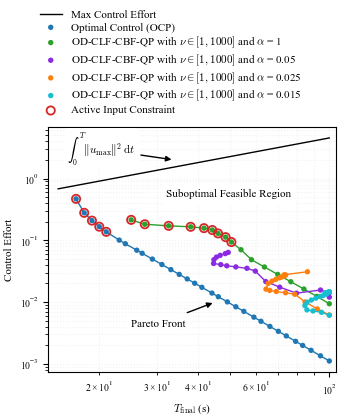

In [7]:
# Pareto Front Plot
fig, ax = plt.subplots(figsize=(3.41, 4.2), layout='constrained')

# ax.scatter(Tfinals[14:], 3 * u_max ** 2 * Tfinals[14:], s=15, zorder=2, facecolors='black', edgecolors='none', marker='o')
ax.plot(Tfinals[14:], 3 * u_max ** 2 * Tfinals[14:], color='black', linestyle='solid', label='Max Control Effort')

# Scatter plot for J_NonlinearOptimalControl with first 15 points removed
ax.scatter(Tfinals[16:], J_NonlinearOptimalControl[16:], s=15, zorder=3, facecolors='tab:blue', edgecolors='none', marker='o', label='Optimal Control (OCP)')
ax.plot(Tfinals[16:], J_NonlinearOptimalControl[16:], color='tab:blue', linestyle='solid')

# ax.scatter(Tpoints_ODCLF_R_gains[:][0, :-1] * dt, J_OptimalDecayCLF_R_gains[:][0, :-1] * dt, s=30, zorder=2, facecolors='navy', edgecolors='none', marker='X', label=f'OD-CLF-QP with $\\nu \in [{R_gains[0]}, {R_gains[-1]}]$')
# ax.plot(Tpoints_ODCLF_R_gains[:][0, :-1] * dt, J_OptimalDecayCLF_R_gains[:][0, :-1] * dt, color='navy', linestyle='solid')
# ax.scatter(Tpoints_ODCLF_R_gains_active_input_constraint[0] * dt, J_OptimalDecayCLF_R_gains[0, np.where(np.isin(Tpoints_ODCLF_R_gains[0], Tpoints_ODCLF_R_gains_active_input_constraint[0]))[0]] * dt, s=35, zorder=3, facecolors='none', edgecolors='tab:red', alpha=1, linewidths=1.3)

colors = ['tab:green', 'blueviolet', 'tab:orange', 'tab:cyan']
for i, a in enumerate(alpha):
    ax.scatter(Tpoints_alphas_R_gains[i, :-1] * dt, J_OptimalDecayCLFCBF_alphas_R_gains[i, :-1] * dt, s=15, zorder=2, facecolors=colors[i], edgecolors='none', marker='o', label=f'OD-CLF-CBF-QP with $\\nu \in [{R_gains[0]}, {R_gains[-1]}]$ and $\\alpha$ = {a}')
    ax.scatter(Tpoints_alphas_R_gains_active_input_constraint[i]  * dt, J_OptimalDecayCLFCBF_alphas_R_gains[i, np.where(np.isin(Tpoints_alphas_R_gains[i, :], Tpoints_alphas_R_gains_active_input_constraint[i]))[0]] * dt, s=35, zorder=3, facecolors='none', edgecolors='tab:red', alpha=1, linewidths=1.3)
    # ax.scatter(Tpoints_alphas_R_gains_active_state_constraint[i]  * dt, J_OptimalDecayCLFCBF_alphas_R_gains[i, np.where(np.isin(Tpoints_alphas_R_gains[i, :], Tpoints_alphas_R_gains_active_state_constraint[i]))[0]] * dt, s=80, zorder=2, facecolors='none', edgecolors='y', alpha=1, linewidths=1.3)
    ax.plot(Tpoints_alphas_R_gains[i, :-1] * dt, J_OptimalDecayCLFCBF_alphas_R_gains[i, :-1] * dt, color=colors[i], linestyle='solid')
    
ax.scatter(Tpoints_active_input_constraint[16:], J_NonlinearOptimalControl[np.where(np.isin(Tfinals, Tpoints_active_input_constraint))[0]][16:], s=35, zorder=2, facecolors='none', edgecolors='tab:red', alpha=1, label='Active Input Constraint', linewidths=1.3)

# Labels and limits
fig.legend(loc='outside upper center', framealpha=0, edgecolor='none', facecolor='white').set_zorder(2)
plt.ylabel('Control Effort')
plt.xlabel('$T_\\text{final}$ (s)')
plt.yscale('log')
plt.xscale('log')
plt.annotate('Pareto Front', xy=(45, 0.01), xytext=(25, 0.004), arrowprops=dict(arrowstyle='-|>', facecolor='k'), bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.4'))
plt.annotate('$\int_{0}^{T}\|u_\\text{max}\|^2\,\mathrm{d}t$', fontweight='bold', xy=(33.8, 2), xytext=(16, 2.5), arrowprops=dict(arrowstyle='-|>', facecolor='k'), bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.2'))
plt.annotate('Suboptimal Feasible Region', xy=(32, 0.5), bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.4'))
plt.xlim([14, 105])
plt.grid(True, zorder=0, color='0.95', linestyle='dotted', which='both', axis='both')
# Show the plot
plt.show()
fig.savefig('figs/pareto_front.pdf')


## Trajectory Simulations

In [8]:
tspan = [0, 45]  # for controllers' comparison plot

In [9]:
## Spacecraft Simulation Using Saturated PD Controller
# Initialize time and state vectors
t = np.arange(tspan[0], tspan[1] + dt, dt)
u = np.zeros((3, len(t)))
x = np.zeros((9, len(t)))
x[:, 0] = x0

kp = 0.4
kd = 0.8

start_time = time.time()

for i in range(len(t) - 1):
    # Get the control input
    u[:, i] = saturated_pd(kp, kd, x[:, i])
    for j in range(3):
        if u[j, i] > u_max:
            u[j, i] = u_max
        elif u[j, i] < u_min:
            u[j, i] = u_min

    # Solve the ODE between t[i] and t[i+1] using u[:, i]
    t_temp = np.array([t[i], t[i+1]])
    x_temp = odeint(spacecraft_plant, t=t_temp, y0=x[:, i], args=(u[:, i], None), tfirst=True)
    x[:, i+1] = np.array(x_temp[-1, :])
    
end_time = time.time()
elapsed_time = end_time - start_time

print(f'Elapsed time: {elapsed_time} second')
print(f'Elapsed time: {elapsed_time/60} minutes')

psi = np.array([mrps_to_euler(x[0:3, i]) * (180 / np.pi) for i in range(len(t))]).T

## Data for the Saturated PD Controller
psi_SaturatedPD = psi
u_SaturatedPD = u
x_SaturatedPD = x
t_SaturatedPD = t

Cost_SaturatedPD = np.trace(u_SaturatedPD.T @ u_SaturatedPD) * dt
print(f'Cost_SaturatedPD: {Cost_SaturatedPD}')

Elapsed time: 0.10336899757385254 second
Elapsed time: 0.0017228166262308756 minutes
Cost_SaturatedPD: 0.1892634028814332


In [10]:
## Spacecraft Simulation Using RES-CLF-QP
# Initialize time and state vectors
t = np.arange(tspan[0], tspan[1] + dt, dt)
u = np.zeros((3, len(t)))
rho = np.zeros(len(t))
delta = np.zeros(len(t))
x = np.zeros((9, len(t)))
x[:, 0] = x0

p_delta = 100

start_time = time.time()

for i in range(len(t) - 1):
    # Get the control input
    u[:, i], rho[i], delta[i] = res_clf_qp(t[i], x[:, i], p_delta)

    # Solve the ODE between t[i] and t[i+1] using u[:, i]
    t_temp = np.array([t[i], t[i+1]])
    x_temp = odeint(spacecraft_plant, t=t_temp, y0=x[:, i], args=(u[:, i], None), tfirst=True)
    x[:, i+1] = np.array(x_temp[-1, :])

end_time = time.time()
elapsed_time = end_time - start_time

print(f'Elapsed time: {elapsed_time} second')
print(f'Elapsed time: {elapsed_time/60} minutes')

psi = np.array([mrps_to_euler(x[0:3, i]) * (180 / np.pi) for i in range(len(t))]).T

## Data for RES-CLF-QP
psi_RESCLF = psi
rho_RESCLF = rho
delta_RESCLF = delta
u_RESCLF = u
x_RESCLF = x
t_RESCLF = t

Cost_RESCLF = np.trace(u_RESCLF.T @ u_RESCLF) * dt
print(f'Cost_RESCLF: {Cost_RESCLF}')

Elapsed time: 1.3767061233520508 second
Elapsed time: 0.022945102055867514 minutes
Cost_RESCLF: 0.8002920380135775


In [11]:
## Spacecraft Simulation Using Optimal-Decay CLF-QP
# Initialize time and state vectors
t = np.arange(tspan[0], tspan[1] + dt, dt)
u = np.zeros((3, len(t)))
rho = np.zeros(len(t))
delta = np.zeros(len(t))
x = np.zeros((9, len(t)))
x[:, 0] = x0
R_gain = 10
alpha = 0.05
p_delta = 100
p_rho = 0.1
rho_0 = 1

start_time = time.time()

for i in range(len(t) - 1):
    # Get the control input
    u[:, i], rho[i], delta[i] = od_clf_qp(t[i], x[:, i], R_gain, alpha, rho_0, p_rho, p_delta)
    
    # Solve the ODE between t[i] and t[i+1] using u[:, i]
    t_temp = np.array([t[i], t[i+1]])
    x_temp = odeint(spacecraft_plant, t=t_temp, y0=x[:, i], args=(u[:, i], None), tfirst=True)
    x[:, i+1] = np.array(x_temp[-1, :])
    
end_time = time.time()
elapsed_time = end_time - start_time

print(f'Elapsed time: {elapsed_time} second')
print(f'Elapsed time: {elapsed_time/60} minutes')

psi = np.array([mrps_to_euler(x[0:3, i]) * (180 / np.pi) for i in range(len(t))]).T

## Data for Optimal-Decay CLF-QP
psi_OptimalDecayCLF = psi
rho_OptimalDecayCLF = rho
delta_OptimalDecayCLF = delta
u_OptimalDecayCLF = u
x_OptimalDecayCLF = x
t_OptimalDecayCLF = t

Cost_OptimalDecayCLF = np.trace(u_OptimalDecayCLF.T @ u_OptimalDecayCLF) * dt
print(f'Cost_OptimalDecayCLF: {Cost_OptimalDecayCLF}')

delta_ODCLFWOrho = delta

Elapsed time: 1.7253341674804688 second
Elapsed time: 0.028755569458007814 minutes
Cost_OptimalDecayCLF: 0.17448269012286574


In [12]:
## Spacecraft Simulation Using Optimal-Decay CLF-QP without rho
# Initialize time and state vectors
t = np.arange(tspan[0], tspan[1] + dt, dt)
u = np.zeros((3, len(t)))
rho = np.zeros(len(t))
delta = np.zeros(len(t))
x = np.zeros((9, len(t)))
x[:, 0] = x0
R_gain = 10
alpha = 0.05
p_delta = 100
p_rho = 0.1
rho_0 = 1

start_time = time.time()

for i in range(len(t) - 1):
    # Get the control input
    u[:, i], rho[i], delta[i] = od_clf_qp_WO_rho(t[i], x[:, i], R_gain, alpha, rho_0, p_rho, p_delta)
    
    # Solve the ODE between t[i] and t[i+1] using u[:, i]
    t_temp = np.array([t[i], t[i+1]])
    x_temp = odeint(spacecraft_plant, t=t_temp, y0=x[:, i], args=(u[:, i], None), tfirst=True)
    x[:, i+1] = np.array(x_temp[-1, :])
    
end_time = time.time()
elapsed_time = end_time - start_time

print(f'Elapsed time: {elapsed_time} second')
print(f'Elapsed time: {elapsed_time/60} minutes')

psi = np.array([mrps_to_euler(x[0:3, i]) * (180 / np.pi) for i in range(len(t))]).T

## Data for Optimal-Decay CLF-QP without rho
delta_ODCLFWOrho = delta
t_ODCLFWOrho = t


Elapsed time: 1.4173569679260254 second
Elapsed time: 0.023622616132100423 minutes


In [13]:
## Spacecraft Simulation Using Nonlinear Optimal Control
# Define the spacecraft dynamics as an input/output system
spacecraft = ct.NonlinearIOSystem(spacecraft_plant, spacecraft_output, states=9, name='spacecraft', inputs=('u_1', 'u_2', 'u_3'), outputs=('sigma_1', 'sigma_2', 'sigma_3', 'omega_1', 'omega_2', 'omega_3', 'h_w1', 'h_w2', 'h_w3'))

# Define cost
u0 = [0., 0., 0.]
xf = [0., 0., 0., 0., 0., 0., 0., 0., 0.]
uf = [0., 0., 0.]
Tf = tspan[1]

Q = np.diag([1, 1, 1, 1, 1, 1, 1, 1, 1]) * 1           # states penalty
R = np.diag([1, 1, 1])                                 # inputs penalty
Qf = np.diag([1, 1, 1, 1, 1, 1, 1, 1, 1]) * 10000      # get close to final point

traj_cost = obc.quadratic_cost(spacecraft, None, R)
# term_cost = obc.quadratic_cost(spacecraft, Qf, 0, x0=xf, u0=uf)

# Define constraints
constraints = [obc.state_range_constraint(spacecraft, [-1, -1, -1, -1, -1, -1, h_min, h_min, h_min], [1, 1, 1, 1, 1, 1, h_max, h_max, h_max]),
               obc.input_range_constraint(spacecraft, [u_min, u_min, u_min], [u_max, u_max, u_max])]

sigma_threshold = 0.02
omega_threshold = 0.005
term_constraint = [obc.state_range_constraint(spacecraft, [-sigma_threshold, -sigma_threshold, -sigma_threshold, -omega_threshold, -omega_threshold, -omega_threshold, h_min, h_min, h_min], [sigma_threshold, sigma_threshold, sigma_threshold, omega_threshold, omega_threshold, omega_threshold, h_max, h_max, h_max]),
                   obc.input_range_constraint(spacecraft, [u_min, u_min, u_min], [u_max, u_max, u_max])]

# Solve for optimal inputs
timepts = np.linspace(0, Tf, 20, endpoint=True) # Best is 20

start_time = time.time()

result = obc.solve_ocp(spacecraft, timepts, x0, traj_cost,
                    trajectory_constraints=constraints,
                    #    terminal_cost=term_cost,
                    initial_guess=u0,
                    terminal_constraints=term_constraint,
                    print_summary=True,
                    minimize_method='SLSQP',
                    minimize_options={'maxiter':300, 'disp':True, 'ftol':1.0e-8},
                    minimize_kwargs={'tol':1.0e-6},
                    # basis=flat.BezierFamily(6, T=Tf),
                    solve_ivp_method='RK45',
                    solve_ivp_kwargs={'atol':1e-6, 'rtol':1e-3},
                    
                    # minimize_method='SLSQP',
                    # minimize_options={'maxiter':300, 'disp':True, 'ftol':1.0e-5},
                    # minimize_kwargs={'tol':1.0e-5},
                    # solve_ivp_kwargs={'method':'DOP853', 'atol':1e-15, 'rtol':1e-12},
                    )

# Simulate the system dynamics (open loop)
resp = ct.input_output_response(spacecraft, timepts, result.inputs, x0, t_eval=np.linspace(0, Tf, Tf*10 + 1))
t, x, u = resp.time, resp.outputs, resp.inputs

end_time = time.time()
elapsed_time = end_time - start_time

print(f'Elapsed time: {elapsed_time} second')
print(f'Elapsed time: {elapsed_time/60} minutes')

psi = np.array([mrps_to_euler(x[0:3, i]) * (180 / np.pi) for i in range(len(t))]).T

h_threshold = 0.01
if np.any(np.logical_and((h_max - h_threshold) <= x[6, :], x[6, :] <= (h_max + h_threshold))) or np.any(np.logical_and((h_min - h_threshold) <= x[6, :], x[6, :] <= (h_min + h_threshold))) or np.any(np.logical_and((h_max - h_threshold) <= x[7, :], x[7, :] <= (h_max + h_threshold))) or np.any(np.logical_and((h_min - h_threshold) <= x[7, :], x[7, :] <= (h_min + h_threshold))) or np.any(np.logical_and((h_max - h_threshold) <= x[8, :], x[8, :] <= (h_max + h_threshold))) or np.any(np.logical_and((h_min - h_threshold) <= x[8, :], x[8, :] <= (h_min + h_threshold))):
    print('h_max or h_min reached')

if np.any(u[0, :] >= u_max) or np.any(u[0, :] <= u_min) or np.any(u[1, :] >= u_max) or np.any(u[1, :] <= u_min) or np.any(u[2, :] >= u_max) or np.any(u[2, :] <= u_min):
    print('u_max or u_min reached')
    
psi_OptimalControl = psi
u_OptimalControl = u
x_OptimalControl = x
t_OptimalControl = t

print(f'Cost_OptimalControl: {result.cost}')

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.013030629787261718
            Iterations: 72
            Function evaluations: 17355
            Gradient evaluations: 72
Summary statistics:
* Cost function calls: 17355
* Constraint calls: 17669
* System simulations: 1
* Final cost: 0.013030629787261718
Elapsed time: 16.294114112854004 second
Elapsed time: 0.2715685685475667 minutes
Cost_OptimalControl: 0.013030629787261718


In [14]:
## Spacecraft Simulation Using Optimal-Decay CLF-CBF-QP
# Initialize time and state vectors
t = np.arange(tspan[0], tspan[1] + dt, dt)
u = np.zeros((3, len(t)))
rho = np.zeros(len(t))
delta = np.zeros(len(t))
x = np.zeros((9, len(t)))
x[:, 0] = x0
R_gain = 10
alpha = 0.05
p_delta = 100
p_rho = 0.1
rho_0 = 1

start_time = time.time()

for i in range(len(t) - 1):
    # Get the control input
    u[:, i], rho[i], delta[i] = od_clf_cbf_qp(t[i], x[:, i], R_gain, alpha, rho_0, p_rho, p_delta)

    # Solve the ODE between t[i] and t[i+1] using u[:, i]
    t_temp = np.array([t[i], t[i+1]])
    x_temp = odeint(spacecraft_plant, t=t_temp, y0=x[:, i], args=(u[:, i], None), tfirst=True)
    x[:, i+1] = np.array(x_temp[-1, :])
    
end_time = time.time()
elapsed_time = end_time - start_time

print(f'Elapsed time: {elapsed_time} second')
print(f'Elapsed time: {elapsed_time/60} minutes')

psi = np.array([mrps_to_euler(x[0:3, i]) * (180 / np.pi) for i in range(len(t))]).T

## Data for Optimal-Decay CLF-CBF-QP
psi_OptimalDecayCLFCBF = psi
rho_OptimalDecayCLFCBF = rho
delta_OptimalDecayCLFCBF = delta
u_OptimalDecayCLFCBF = u
x_OptimalDecayCLFCBF = x
t_OptimalDecayCLFCBF = t

Cost_OptimalDecayCLFCBF = np.trace(u_OptimalDecayCLFCBF.T @ u_OptimalDecayCLFCBF) * dt
print(f'Cost_OptimalDecayCLFCBF: {Cost_OptimalDecayCLFCBF}')

Elapsed time: 1.896841049194336 second
Elapsed time: 0.03161401748657226 minutes
Cost_OptimalDecayCLFCBF: 0.04305871528585451


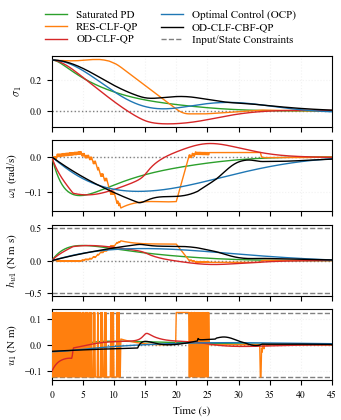

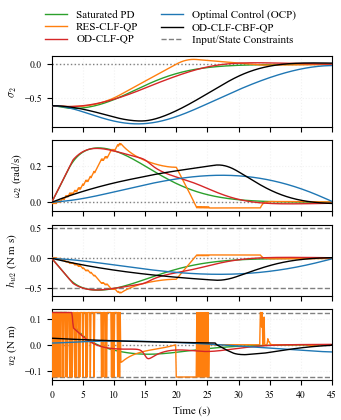

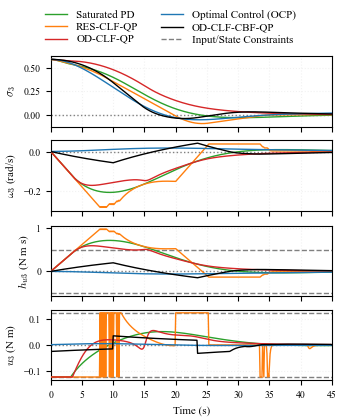

In [15]:
# Plot all controllers
selected_controllers = ['1', '2', '3', '4', '5']
input_list = ['1', '2', '3', '4', '5']

# Flexible data storage
controllers_data = {
    '1': {'label': 'Saturated PD', 'color': 'tab:green', 'x': x_SaturatedPD, 'u': u_SaturatedPD, 't': t_SaturatedPD},
    '2': {'label': 'RES-CLF-QP', 'color': 'tab:orange', 'x': x_RESCLF, 'u': u_RESCLF, 't': t_RESCLF},
    '3': {'label': 'OD-CLF-QP', 'color': 'tab:red', 'x': x_OptimalDecayCLF, 'u': u_OptimalDecayCLF, 't': t_OptimalDecayCLF},
    '4': {'label': 'Optimal Control (OCP)', 'color': 'tab:blue', 'x': x_OptimalControl, 'u': u_OptimalControl, 't': t_OptimalControl},
    '5': {'label': 'OD-CLF-CBF-QP', 'color': 'black', 'x': x_OptimalDecayCLFCBF, 'u': u_OptimalDecayCLFCBF, 't': t_OptimalDecayCLFCBF}
}

for i in range(0, 3):
    # Create subplots
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(3.41, 4.2), sharex=True, layout='constrained')

    # Plot for each selected controller
    for controller in selected_controllers:
        if controller in input_list:
            data = controllers_data[controller]
            ax1.plot(data['t'], data['x'][i, :], linestyle='solid', color=data['color'], zorder=3, label=data['label'])
            ax2.plot(data['t'], data['x'][i+3, :], linestyle='solid', color=data['color'], zorder=3)
            ax3.plot(data['t'], data['x'][i+6, :], linestyle='solid', color=data['color'], zorder=3)
            ax4.plot(data['t'], data['u'][i, :], linestyle='solid', color=data['color'], zorder=3)

    # Add reference lines and labels
    ax1.hlines(y=0, xmin=0, xmax=t[-1], color="grey", linestyle="dotted", zorder=2)
    ax1.set_ylabel(fr"$\sigma_{{{i+1}}}$")

    ax2.hlines(y=0, xmin=0, xmax=t[-1], color="grey", linestyle="dotted", zorder=2)
    ax2.set_ylabel(fr"$\omega_{{{i+1}}}$ (rad/s)")

    ax3.hlines(y=0, xmin=0, xmax=t[-1], color="grey", linestyle="dotted", zorder=2)
    ax3.hlines(y=h_max, xmin=0, xmax=t[-1], color="grey", linestyle="dashed", zorder=2, label="Input/State Constraints")
    ax3.hlines(y=h_min, xmin=0, xmax=t[-1], color="grey", linestyle="dashed", zorder=2)
    ax3.set_ylabel(fr"$h_{{w{i+1}}}$ (N m s)")

    ax4.hlines(y=0, xmin=0, xmax=t[-1], color="grey", linestyle="dotted", zorder=2)
    ax4.hlines(y=u_max, xmin=0, xmax=t[-1], color="grey", linestyle="dashed", zorder=2)
    ax4.hlines(y=u_min, xmin=0, xmax=t[-1], color="grey", linestyle="dashed", zorder=2)
    ax4.set_ylabel(fr"$u_{{{i+1}}}$ (N m)")

    # Autoscale and add grids
    for ax in [ax1, ax2, ax3, ax4]:
        ax.autoscale(enable=True, axis="x", tight=True)
        ax.grid(True, zorder=0, color="0.95", linestyle="dotted", which="both", axis="both")

    # Set x-axis label and legend
    plt.xlabel("Time (s)")
    handles, labels = ax1.get_legend_handles_labels()
    constraint_handles, constraint_labels = ax3.get_legend_handles_labels()
    handles += constraint_handles
    labels += constraint_labels
    if handles:  # Only show legend if there are selected controllers
        fig.legend(handles, labels, loc="outside upper center", ncols=2, framealpha=0, edgecolor="none", facecolor="white").set_zorder(2)

    # Show and save the figure
    plt.show()
    fig.savefig(f'figs/trajectories_{i+1}.pdf')

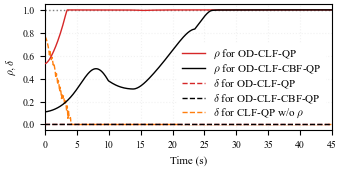

In [22]:
# Plot for rho and delta
rho_0 = 1
fig, (ax1) = plt.subplots(1, figsize=(3.41, 1.7), sharex=True, layout='constrained')
ax1.hlines(y=rho_0, xmin=0, xmax=t[-1], color='grey', linestyle='dotted', zorder=2) #, label=r'$\rho_0$')
ax1.plot(t_OptimalDecayCLF[0:-1], rho_OptimalDecayCLF[0:-1], linestyle='solid', color='tab:red', zorder=3, label=r'$\rho$ for OD-CLF-QP')
ax1.plot(t_OptimalDecayCLFCBF[0:-1], rho_OptimalDecayCLFCBF[0:-1], linestyle='solid', color='black', zorder=3, label=r'$\rho$ for OD-CLF-CBF-QP')
ax1.plot(t_OptimalDecayCLF[0:-1], delta_OptimalDecayCLF[0:-1], linestyle='dashed', color='tab:red', zorder=3, label=r'$\delta$ for OD-CLF-QP')
ax1.plot(t_OptimalDecayCLFCBF[0:-1], delta_OptimalDecayCLFCBF[0:-1], linestyle='dashed', color='black', zorder=3, label=r'$\delta$ for OD-CLF-CBF-QP')
ax1.plot(t_ODCLFWOrho[0:-1], delta_ODCLFWOrho[0:-1], linestyle='dashed', color='tab:orange', zorder=2, label=r'$\delta$ for CLF-QP w/o $\rho$')
ax1.autoscale(enable=True, axis="x", tight=True)

plt.xlabel('Time (s)')
plt.ylabel(r'$\rho, \delta$')
plt.legend(loc='lower right', framealpha=1, edgecolor='none', facecolor='white', labelspacing=0.1).set_zorder(2)
plt.grid(True, zorder=0, color='0.95', linestyle='dotted', which='both', axis='both')
plt.show()
fig.savefig('figs/rho_delta.pdf')

## Monte Carlo Simulations

In [17]:
tspan = [0, 45]  # for Monte Carlo plot

In [18]:
## Monte Carlo Simulations
np.random.seed(80)

def random_euler_321_radians():
    # First rotation (phi) around Z-axis: Uniformly distributed between 0 and 2*pi radians
    phi = np.random.uniform(0, 2 * np.pi)
    # Second rotation (theta) around Y-axis: Uniformly distributed as sin^2(theta) for solid angle uniformity
    # The correct distribution for theta in a 3-2-1 sequence is simply uniform for cos(theta)
    theta = np.arccos(1 - 2 * np.random.rand())
    # Third rotation (psi) around X-axis: Uniformly distributed between 0 and 2*pi radians
    psi = np.random.uniform(0, 2 * np.pi)
    return np.array([phi, theta, psi])

random_initial_states = [random_euler_321_radians() for _ in range(20)]
theta = np.zeros((len(random_initial_states), 3))
sigmai = np.zeros((len(random_initial_states), 3))
x0 = np.zeros((len(random_initial_states), 9))
u = []
rho = []
delta = []
x = []
psi = []

R_gain = 10
alpha = 1
p_delta = 100
p_rho = 0.1
rho_0 = 1

for k, initial_state in enumerate(random_initial_states):
    theta[k] = initial_state
    sigmai[k] = euler_to_mrps(theta[k])
    wi = np.array([0.1, 0.1, 0.1]) * 0
    hi = np.array([0., 0., 0.])
    x0[k] = [sigmai[k][0], sigmai[k][1], sigmai[k][2], wi[0], wi[1], wi[2], hi[0], hi[1], hi[2]]
    # Initialize time and state vectors
    t = np.arange(tspan[0], tspan[1] + dt, dt)
    u.append(np.zeros((3, len(t))))  # Append an empty array to u
    rho.append(np.zeros(len(t)))
    delta.append(np.zeros(len(t)))
    x.append(np.zeros((9, len(t))))
    x[k][:, 0] = x0[k]

    start_time = time.time()

    for i in range(len(t) - 1):
        # Get the control input
        u[k][:, i], rho[k][i], delta[k][i] = od_clf_cbf_qp(t[i], x[k][:, i], R_gain, alpha, rho_0, p_rho, p_delta)
        #clf_cbf_qp_controller(t[i], x[k][:, i], alpha)

        # Solve the ODE between t[i] and t[i+1] using u[:, i]
        t_temp = np.array([t[i], t[i+1]])
        x_temp = odeint(spacecraft_plant, t=t_temp, y0=x[k][:, i], args=(u[k][:, i], None), tfirst=True)
        x[k][:, i+1] = np.array(x_temp[-1, :])

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f'Elapsed time: {elapsed_time} seconds')
    print(f'Elapsed time: {elapsed_time/60} minutes')
    
    psi.append(np.array([mrps_to_euler(x[k][0:3, i]) * (180 / np.pi) for i in range(len(t))]).T)

Elapsed time: 1.881890058517456 seconds
Elapsed time: 0.031364834308624266 minutes
Elapsed time: 1.8318159580230713 seconds
Elapsed time: 0.030530265967051187 minutes
Elapsed time: 1.9161632061004639 seconds
Elapsed time: 0.03193605343500773 minutes
Elapsed time: 1.8103282451629639 seconds
Elapsed time: 0.03017213741938273 minutes
Elapsed time: 1.7823867797851562 seconds
Elapsed time: 0.029706446329752605 minutes
Elapsed time: 1.795961856842041 seconds
Elapsed time: 0.029932697614034016 minutes
Elapsed time: 1.7687580585479736 seconds
Elapsed time: 0.02947930097579956 minutes
Elapsed time: 1.7804279327392578 seconds
Elapsed time: 0.02967379887898763 minutes
Elapsed time: 1.7607388496398926 seconds
Elapsed time: 0.02934564749399821 minutes
Elapsed time: 1.7899460792541504 seconds
Elapsed time: 0.02983243465423584 minutes
Elapsed time: 1.7482221126556396 seconds
Elapsed time: 0.029137035210927326 minutes
Elapsed time: 1.7845728397369385 seconds
Elapsed time: 0.029742880662282308 minutes


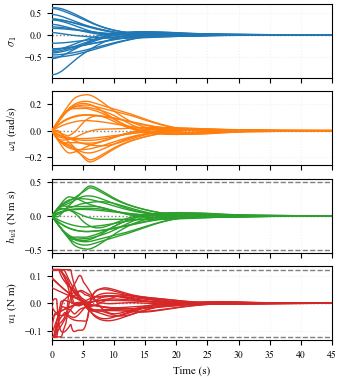

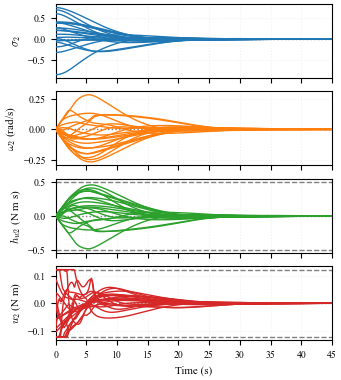

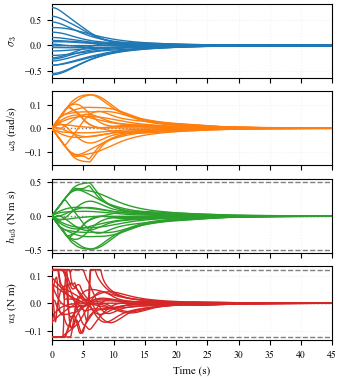

In [19]:
for i in range(0, 3):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(3.41, 3.8), sharex=True, layout='constrained')
    for k in range(len(random_initial_states)):
        ax1.plot(t, x[k][i, :], linestyle='solid', color='tab:blue', zorder=3)
        ax2.plot(t, x[k][i+3, :], linestyle='solid', color='tab:orange', zorder=3)
        ax3.plot(t, x[k][i+6, :], linestyle='solid', color='tab:green', zorder=3)
        ax4.plot(t, u[k][i, :], linestyle='solid', color='tab:red', zorder=3)

    ax1.hlines(y=0, xmin=0, xmax=t[-1], color='grey', linestyle='dotted', zorder=2)
    ax2.hlines(y=0, xmin=0, xmax=t[-1], color='grey', linestyle='dotted', zorder=2)
    ax3.hlines(y=0, xmin=0, xmax=t[-1], color='grey', linestyle='dotted', zorder=2)
    ax4.hlines(y=0, xmin=0, xmax=t[-1], color='grey', linestyle='dotted', zorder=2)

    ax3.hlines(y=h_min, xmin=0, xmax=t[-1], color='grey', linestyle='dashed', zorder=2)
    ax3.hlines(y=h_max, xmin=0, xmax=t[-1], color='grey', linestyle='dashed', zorder=2)
    ax4.hlines(y=u_min, xmin=0, xmax=t[-1], color='grey', linestyle='dashed', zorder=2)
    ax4.hlines(y=u_max, xmin=0, xmax=t[-1], color='grey', linestyle='dashed', zorder=2)

    ax1.set_ylabel(fr'$\sigma_{{{i+1}}}$')
    ax2.set_ylabel(fr'$\omega_{{{i+1}}}$ (rad/s)')
    ax3.set_ylabel(fr'$h_{{w{i+1}}}$ (N m s)')
    ax4.set_ylabel(fr'$u_{{{i+1}}}$ (N m)')

    # Autoscale and add grids
    for ax in [ax1, ax2, ax3, ax4]:
        ax.autoscale(enable=True, axis="x", tight=True)
        ax.grid(True, zorder=0, color="0.95", linestyle="dotted", which="both", axis="both")

    plt.xlabel('Time (s)')
    plt.show()
    fig.savefig(f'figs/montecarlo_{i+1}.pdf')

In [20]:
## Imports the environment
# conda env create -f spacecraft_environment.yml